In [1]:
import tensorflow as tf
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import cv2

## To do list 
1. Add mlp
2. run with smaller h_dim and z_dim 
3. minority class only VAE
4. Meeting on monday

# To do list 2
1. drop smaller classes ecoli
2. reduce the number of samples in the mnist (1:10, 1:15, 1:20)
3. averaging all experiments over ten runs
4. introduce imbalance in optical digits (one minority class)
5. trying different encoding dim n/2, n/4, ... 

In [2]:
(train_images, train_labels), (test_images,test_labels) = tf.keras.datasets.mnist.load_data()

In [3]:
train_images = [np.reshape(x, -1) for x in train_images]
test_images= [np.reshape(x, -1) for x in test_images]
train_images[0].shape

(784,)

In [4]:

def group_all_labels(data, num=100, minor=[]):
    # this function is to limit the number of labels that are used
    # it returns the indexes according the labels
    # data is an array of labels
    '''

    :param data: array of labels
    :param num: number required
    :param minor: list of minority indexes
    :return: array of labels indexes
    '''

    labels = np.unique(data)
    co_l = []
    min_col =[]
    if not minor:
        for l in labels:
            el_l = np.where(np.array(data) == l)
            co_l.append(el_l[0])

    else:
        for l in labels:
            if l in minor:
                el_l = np.where(np.array(data) == l)
                co_l.append((el_l[0])[:num])
                min_col.append((el_l[0])[:num])
            else:
                el_l = np.where(np.array(data) == l)
                co_l.append(el_l[0])
    return co_l, min_col

In [5]:
grouped_labels, min_label = group_all_labels(train_labels, 250, [0, 1])
gr_data = []
gr_labels = [] 
for index, q in enumerate(grouped_labels):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_data.append(train_images[r])
        gr_labels.append(train_labels[r])

gr_min_data = []
gr_min_labels = []

class 0 : number of samples : 250
class 1 : number of samples : 250
class 2 : number of samples : 5958
class 3 : number of samples : 6131
class 4 : number of samples : 5842
class 5 : number of samples : 5421
class 6 : number of samples : 5918
class 7 : number of samples : 6265
class 8 : number of samples : 5851
class 9 : number of samples : 5949


In [6]:
print('minority data only')
gr_min_data = []
gr_min_labels = []
for index, q in enumerate(min_label):
    print('class {} : number of samples : {}'.format(index,len(q)))
    for r in q:
        gr_min_data.append(train_images[r])
        gr_min_labels.append(train_labels[r])


minority data only
class 0 : number of samples : 250
class 1 : number of samples : 250


[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]


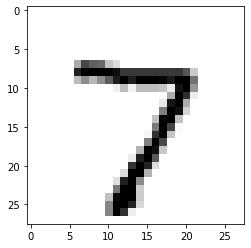

In [7]:
train_x = np.array(gr_data)
train_x = (train_x.astype(np.float32) / 255.0) 
test_x =  np.array(test_images)
test_images = (test_x.astype(np.float32)/255.0)

train_min_x = np.array(gr_min_data)
train_min_x = (train_min_x.astype(np.float32) / 255.0) 

train_y = tf.keras.utils.to_categorical(gr_labels, num_classes=10, dtype='float32')
test_y = tf.keras.utils.to_categorical(test_labels, num_classes=10, dtype='float32')
train_min_y = tf.keras.utils.to_categorical(gr_min_labels, num_classes=2, dtype='float32')

print(test_y[0])
plt.imshow(np.reshape(test_x[0],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')

#  VAE Model

In [8]:
import tensorflow.compat.v1  as tf
tf.disable_v2_behavior()
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import os
import numpy as np

mb_size = 64
z_dim = 100
X_dim = 784
y_dim = 10
h_dim = 128
lr = 1e-3


def plot(samples, sz, shape):
    fig = plt.figure(figsize=(sz, sz))
    gs = gridspec.GridSpec(sz, sz)
    gs.update(wspace=0.05, hspace=0.05)

    for i, sample in enumerate(samples):
        ax = plt.subplot(gs[i])
        plt.axis('off')
        ax.set_xticklabels([])
        ax.set_yticklabels([])
        ax.set_aspect('equal')
        plt.imshow(sample.reshape(shape, shape), cmap='Greys_r')

    return fig


def xavier_init(size):
    in_dim = size[0]
    xavier_stddev = 1. / tf.sqrt(in_dim / 2.)
    return tf.random.normal(shape=size, stddev=xavier_stddev)


# Q(z|X) 

X = tf.keras.Input(shape=(X_dim,))
c = tf.keras.Input(shape=(y_dim,))
z = tf.keras.Input(shape=(z_dim,))

Q_W1 = tf.Variable(xavier_init([X_dim + y_dim, h_dim]))
Q_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

Q_W2_mu = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_mu = tf.Variable(tf.zeros(shape=[z_dim]))

Q_W2_sigma = tf.Variable(xavier_init([h_dim, z_dim]))
Q_b2_sigma = tf.Variable(tf.zeros(shape=[z_dim]))


def Q(X, c):
    inputs = tf.concat(axis=1, values=[X, c])
    h = tf.nn.relu(tf.matmul(inputs, Q_W1) + Q_b1)
    z_mu = tf.matmul(h, Q_W2_mu) + Q_b2_mu
    z_logvar = tf.matmul(h, Q_W2_sigma) + Q_b2_sigma
    return z_mu, z_logvar


def sample_z(mu, log_var):
    eps = tf.random.normal(shape=tf.shape(mu))
    return mu + tf.exp(log_var / 2) * eps


# P(X|z)

P_W1 = tf.Variable(xavier_init([z_dim + y_dim, h_dim]))
P_b1 = tf.Variable(tf.zeros(shape=[h_dim]))

P_W2 = tf.Variable(xavier_init([h_dim, X_dim]))
P_b2 = tf.Variable(tf.zeros(shape=[X_dim]))


def P(z, c):
    inputs = tf.concat(axis=1, values=[z, c])
    h = tf.nn.relu(tf.matmul(inputs, P_W1) + P_b1)
    logits = tf.matmul(h, P_W2) + P_b2
    prob = tf.nn.sigmoid(logits)
    return prob, logits

z_mu, z_logvar = Q(X, c)
z_sample = sample_z(z_mu, z_logvar)
_, logits = P(z_sample, c)

# Sampling from random z
X_samples, _ = P(z, c)

# E[log P(X|z)]
recon_loss = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(logits=logits, labels=X), 1)
kl_loss = 0.5 * tf.reduce_sum(tf.exp(z_logvar) + z_mu**2 - 1. - z_logvar, 1)

# VAE loss
vae_loss = tf.reduce_mean(recon_loss + kl_loss)

# gradient step
solver = tf.compat.v1.train.AdamOptimizer().minimize(vae_loss)
sess = tf.compat.v1.Session ()
sess.run(
tf.compat.v1.global_variables_initializer())

Instructions for updating:
non-resource variables are not supported in the long term


2021-10-03 22:51:05.430748: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-10-03 22:51:05.437910: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2021-10-03 22:51:05.438712: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1835] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
2021-10-03 22:51:05.439490: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library

In [9]:

if not os.path.exists('vae_mnist_250/'):
    os.makedirs('vae_mnist_250/')

i = 0

for it in range(100000):
    ind = np.random.choice(train_x.shape[0], mb_size)
    X_mb = np.array(train_x[ind])
    y_mb = np.array(train_y[ind])
    
    _, loss = sess.run([solver, vae_loss], feed_dict={X: X_mb, c: y_mb})

    if it % 1000 == 0:
        print('Iter: {:0} Loss: {:0.4}'.format(it, loss))
        
        samples=[]
        for index in range(y_dim):
            y = np.zeros([y_dim, y_dim])
            y[range(y_dim), index] = 1
            samples.extend(sess.run(X_samples,
                           feed_dict={z: np.random.randn(y_dim, z_dim), c: y}))

        fig = plot(samples, 10, 28)
        plt.savefig('vae_mnist_250/{}.png'.format(str(i).zfill(3)), bbox_inches='tight')
        i += 1
        plt.close(fig)

Iter: 0 Loss: 742.8
Iter: 1000 Loss: 143.4
Iter: 2000 Loss: 133.3
Iter: 3000 Loss: 121.1
Iter: 4000 Loss: 123.6
Iter: 5000 Loss: 114.9
Iter: 6000 Loss: 107.6
Iter: 7000 Loss: 111.5
Iter: 8000 Loss: 114.6
Iter: 9000 Loss: 111.2
Iter: 10000 Loss: 107.3
Iter: 11000 Loss: 112.2
Iter: 12000 Loss: 109.7
Iter: 13000 Loss: 111.5
Iter: 14000 Loss: 115.9
Iter: 15000 Loss: 112.2
Iter: 16000 Loss: 106.4
Iter: 17000 Loss: 108.8
Iter: 18000 Loss: 109.4
Iter: 19000 Loss: 106.7
Iter: 20000 Loss: 108.0
Iter: 21000 Loss: 105.6
Iter: 22000 Loss: 108.6
Iter: 23000 Loss: 109.4
Iter: 24000 Loss: 104.3
Iter: 25000 Loss: 110.2
Iter: 26000 Loss: 108.6
Iter: 27000 Loss: 111.6
Iter: 28000 Loss: 108.8
Iter: 29000 Loss: 115.0
Iter: 30000 Loss: 105.5
Iter: 31000 Loss: 107.1
Iter: 32000 Loss: 111.5
Iter: 33000 Loss: 106.5
Iter: 34000 Loss: 108.8
Iter: 35000 Loss: 104.6
Iter: 36000 Loss: 102.7
Iter: 37000 Loss: 100.0
Iter: 38000 Loss: 104.7
Iter: 39000 Loss: 110.4
Iter: 40000 Loss: 107.6
Iter: 41000 Loss: 104.9
Iter:

In [10]:
samples = []
gen_labels =[]
for r in range(62):
    for index in range(2):
        gen_labels = gen_labels + [index]*mb_size
        y = np.zeros([mb_size, y_dim])
        y[range(mb_size), index] = 1
        samples.extend(sess.run(X_samples,
                               feed_dict={z: np.random.randn(mb_size, z_dim), c: y}))

gen_samples = np.array(samples)
gen_labels = np.array(gen_labels)
print(gen_samples.shape)
print(gen_labels.shape)
print(gen_labels[0])

(7936, 784)
(7936,)
0


# Adding and classifying with generated samples

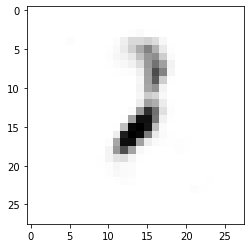

In [11]:
plt.imshow(np.reshape(gen_samples[65],(28,28)), cmap=plt.cm.gray_r, interpolation='nearest')
#np.save('mnist_gen_data.npy', gen_samples)
#np.save('mnist_gen_labels.npy', gen_labels)


In [12]:
X = np.concatenate([train_x, gen_samples])
Y = np.concatenate([np.reshape(gr_labels, -1), gen_labels])

# MLP Experiment 

In [13]:
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Flatten
from tensorflow.keras.models import Sequential

def build_model(input_shape=(784,), num_classes=10):
    """

    :param input_shape: shape of input_data
    :param num_classes: number of classes
    :return: keras.model.sequential compiled with categorical cross-entropy loss
    """
    model = Sequential([
        Input(shape=input_shape),
        Dense(32, activation="relu"),
        BatchNormalization(),
        Dense(64, activation="relu"),
        BatchNormalization(),
        Flatten(),
        Dropout(0.5),
        Dense(num_classes, activation="softmax"),
    ])

    model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
    model.summary()
    return model

In [14]:
bl_model = build_model()
batch_size=64
epochs=30
bl_history = bl_model.fit(train_x, train_y, batch_size=batch_size,
                    epochs=epochs, validation_data=(test_images, test_y))

bl_score = bl_model.evaluate(test_images, test_y, verbose=0)
print('test loss: ', bl_score[0])
print('test accuracy: ', bl_score[1] )

Instructions for updating:
Colocations handled automatically by placer.
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 32)                25120     
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_1 (Batch (None, 64)                256       
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
__________________________________________________

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


47835/47835 [==============================] - 2s 32us/sample - loss: 0.2876 - acc: 0.9156 - val_loss: 0.3568 - val_acc: 0.8878
Epoch 3/30
47835/47835 [==============================] - 2s 32us/sample - loss: 0.2306 - acc: 0.9321 - val_loss: 0.2948 - val_acc: 0.9054
Epoch 4/30
47835/47835 [==============================] - 2s 33us/sample - loss: 0.1979 - acc: 0.9420 - val_loss: 0.2504 - val_acc: 0.9226
Epoch 5/30
47835/47835 [==============================] - 1s 29us/sample - loss: 0.1802 - acc: 0.9461 - val_loss: 0.2021 - val_acc: 0.9409
Epoch 6/30
47835/47835 [==============================] - 1s 31us/sample - loss: 0.1668 - acc: 0.9506 - val_loss: 0.2195 - val_acc: 0.9346
Epoch 7/30
47835/47835 [==============================] - 1s 31us/sample - loss: 0.1549 - acc: 0.9539 - val_loss: 0.1949 - val_acc: 0.9416
Epoch 8/30
47835/47835 [==============================] - 1s 30us/sample - loss: 0.1435 - acc: 0.9568 - val_loss: 0.2258 - val_acc: 0.9345
Epoch 9/30
47835/47835 [==============

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])


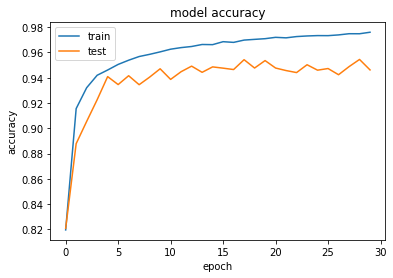

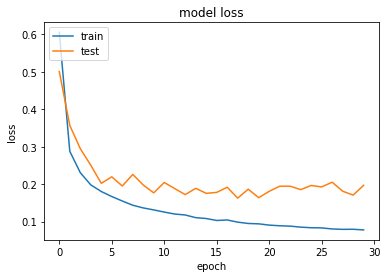

In [15]:
print(bl_history.history.keys())
plt.plot(bl_history.history['acc'])
plt.plot(bl_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(bl_history.history['loss'])
plt.plot(bl_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [16]:
from sklearn.metrics import classification_report
y_pred_oh = bl_model.predict(test_images)
y_pred_baseline = y_pred_oh.argmax(axis=-1)
print('MLP classification baseline\n', classification_report(test_labels, y_pred_baseline))

MLP classification baseline
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       980
           1       0.99      0.88      0.93      1135
           2       0.94      0.97      0.95      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.97      0.96       892
           6       0.94      0.98      0.96       958
           7       0.94      0.97      0.96      1028
           8       0.87      0.97      0.92       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [17]:
# X = np.concatenate([train_x, gen_samples])
# Y = np.concatenate([np.reshape(gr_labels, -1), gen_labels])
Y_oh = np.array(tf.keras.utils.to_categorical(Y, num_classes=10, dtype='float32'))

aug_model = build_model()
aug_history = aug_model.fit(X, Y_oh, batch_size=batch_size,
                    epochs=epochs, validation_data=(test_images, test_y))

aug_score = aug_model.evaluate(test_images, test_y, verbose=0)
print('test loss: ', aug_score[0])
print('test accuracy: ', aug_score[1] )

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 32)                25120     
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_4 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
flatten_1 (Flatten)          (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)               

/media/adamu/data/projects/notebooks/UCI_encoders/imbalance_venv/lib/python3.8/site-packages/keras/engine/training.py:2470: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  warnings.warn('`Model.state_updates` will be removed in a future version. '


Epoch 2/30
55771/55771 [==============================] - 2s 33us/sample - loss: 0.2798 - acc: 0.9172 - val_loss: 0.1936 - val_acc: 0.9430
Epoch 3/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.2267 - acc: 0.9343 - val_loss: 0.1897 - val_acc: 0.9454
Epoch 4/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1925 - acc: 0.9423 - val_loss: 0.1760 - val_acc: 0.9454
Epoch 5/30
55771/55771 [==============================] - 2s 30us/sample - loss: 0.1737 - acc: 0.9488 - val_loss: 0.1571 - val_acc: 0.9526
Epoch 6/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1577 - acc: 0.9529 - val_loss: 0.1502 - val_acc: 0.9564
Epoch 7/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1513 - acc: 0.9562 - val_loss: 0.1572 - val_acc: 0.9535
Epoch 8/30
55771/55771 [==============================] - 2s 31us/sample - loss: 0.1390 - acc: 0.9583 - val_loss: 0.1496 - val_acc: 0.9561
Epoch 9/30
55771/55771 [===

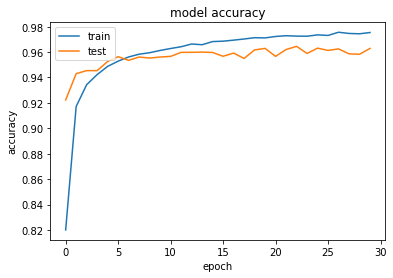

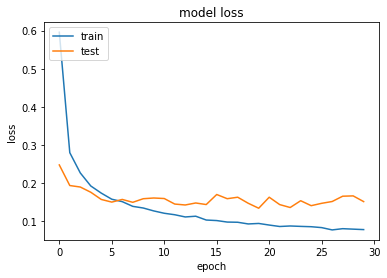

In [18]:
plt.plot(aug_history.history['acc'])
plt.plot(aug_history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(aug_history.history['loss'])
plt.plot(aug_history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [19]:
y_pred_aug_oh = bl_model.predict(test_images)
y_pred_aug = y_pred_aug_oh.argmax(axis=-1)
print('MLP classification Augmented \n', classification_report(test_labels, y_pred_aug))

MLP classification Augmented 
               precision    recall  f1-score   support

           0       0.99      0.84      0.91       980
           1       0.99      0.88      0.93      1135
           2       0.94      0.97      0.95      1032
           3       0.95      0.97      0.96      1010
           4       0.96      0.97      0.96       982
           5       0.96      0.97      0.96       892
           6       0.94      0.98      0.96       958
           7       0.94      0.97      0.96      1028
           8       0.87      0.97      0.92       974
           9       0.94      0.96      0.95      1009

    accuracy                           0.95     10000
   macro avg       0.95      0.95      0.95     10000
weighted avg       0.95      0.95      0.95     10000



In [20]:
print(X.shape)
print(Y_oh.shape)

(55771, 784)
(55771, 10)


In [21]:
print(train_x.shape)
print(train_y.shape)

(47835, 784)
(47835, 10)
